# ¿Cuáles películas tienen críticas negativas?

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
# Importar de librerías
import math

import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
import spacy
import torch
import transformers

from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# Para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
# Cargar datos
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

## EDA

In [5]:
# Ver sample de data
df_reviews.sample(10)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
3788,tt0109266,movie,Bang,Bang,1995,\N,98,0,"Crime,Drama",6.3,473,Not sure why this movie seems to have gotten s...,1,neg,0,train,7896
11487,tt0325950,movie,El padrino,El padrino,2004,\N,128,0,"Action,Crime,Drama",4.9,677,This movie is a picture perfect action/drama/a...,10,pos,1,test,11895
17608,tt0116601,movie,I'm Not Rappaport,I'm Not Rappaport,1996,\N,135,0,"Comedy,Drama",6.5,1520,Two old men sitting on a park bench . I don`t ...,4,neg,0,train,8922
45555,tt0449040,video,War of the Worlds,War of the Worlds,2005,\N,93,0,"Horror,Sci-Fi",3.2,2374,After watching the Steven Spielberg version of...,1,neg,0,test,6275
15746,tt0080835,tvMovie,"Hamlet, Prince of Denmark","Hamlet, Prince of Denmark",1980,\N,210,0,Drama,8.0,525,"This production of Hamlet, Prince of Denmark i...",10,pos,1,test,2079
21204,tt0119591,movie,Macbeth,Macbeth,1997,\N,129,0,Drama,5.1,214,Thank goodness not all Dutch people are that r...,8,pos,1,test,6494
259,tt0062622,movie,2001: A Space Odyssey,2001: A Space Odyssey,1968,\N,149,0,"Adventure,Sci-Fi",8.3,582152,"""200l: A Space Odyssey"" is a supremely intrigu...",9,pos,1,test,2660
1345,tt0117913,movie,A Time to Kill,A Time to Kill,1996,\N,149,0,"Crime,Drama,Thriller",7.5,127061,This is the worst kind of film. The plot is lu...,1,neg,0,test,5355
21861,tt0079540,movie,Meatballs,Meatballs,1979,\N,94,0,Comedy,6.2,18514,Wildman head counselor Tripper Harrison (Bill ...,8,pos,1,test,7055
42758,tt0425638,video,The War of the Worlds,The War of the Worlds,2005,\N,179,0,"Action,Drama,Horror",3.0,1002,I'm not really sure how to even begin to descr...,1,neg,0,train,745


In [6]:
# Ver info de data
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [7]:
# Verificar estadísticas descriptivas
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


Veamos el número de películas y reseñas a lo largo de los años.

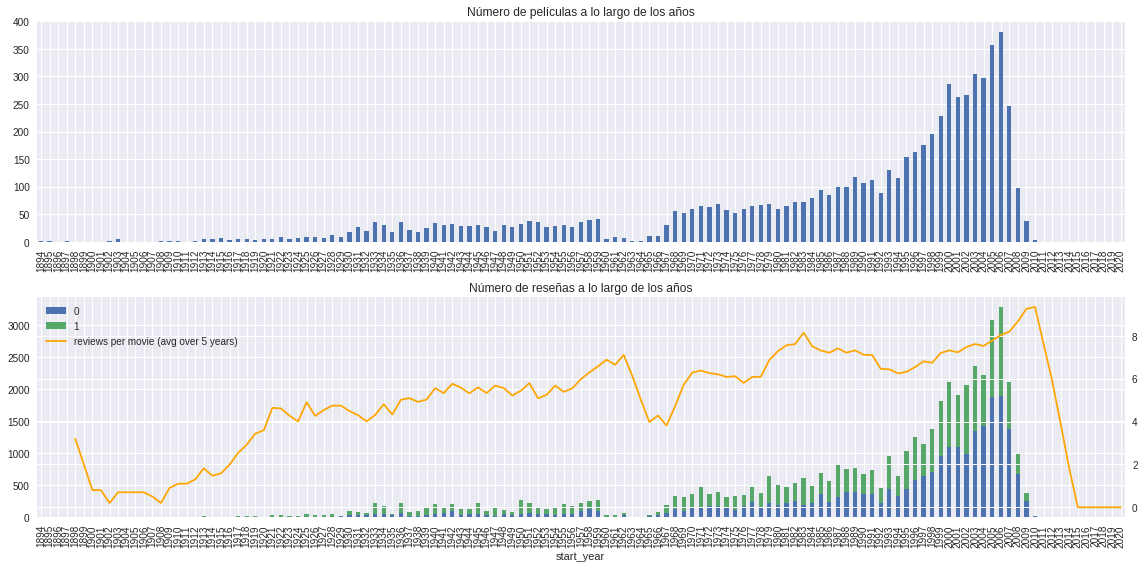

In [8]:
# Graficar número de películas y reseñas
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

# Recoge las líneas y las etiquetas tanto de ax como de axt
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = axt.get_legend_handles_labels()

ax.legend(lines + lines2, labels + labels2, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Se puede observar que la cantidad de reseñas ha ido en aumento conforme han pasado los años.

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto).

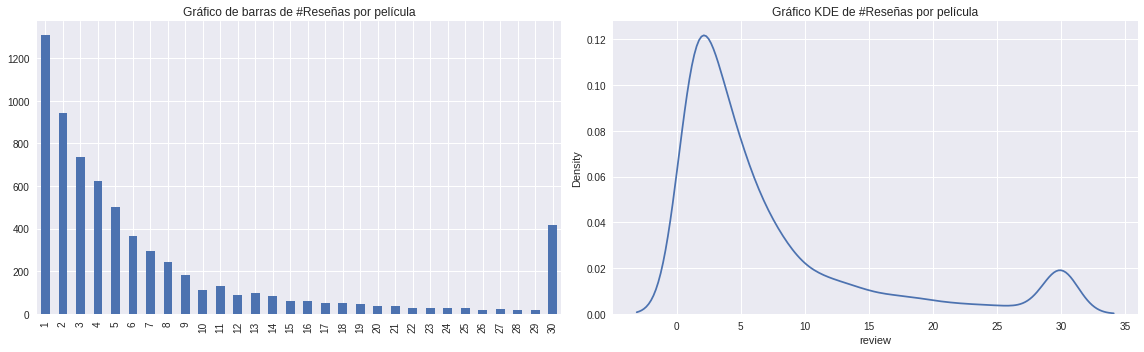

In [9]:
# Graficar número de reseña por película
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

La cantidad de reseñas por películas se encuentra concentrado entre 1 a 9 reseñas. Sin embargo, también hay una concentración considerable de películas que han tenido alrededor de 30 reseñas.

In [10]:
# Verificar balance de clases
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

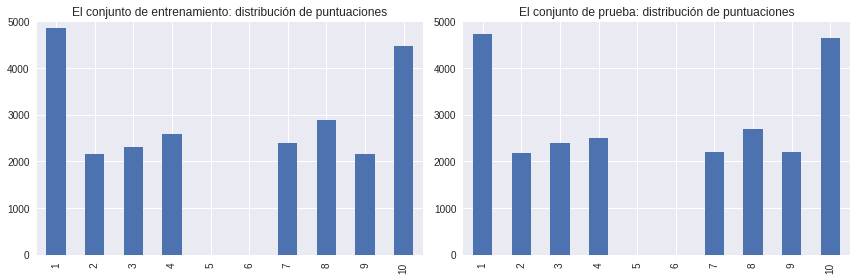

In [11]:
# Graficar distribución de puntuaciones de los conjuntos de entrenamiento y prueba
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Tanto para el conjunto de entrenamiento o de pruebas la distribución de reseñas positivas y negativas es muy similar.

Ahora veamos la distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


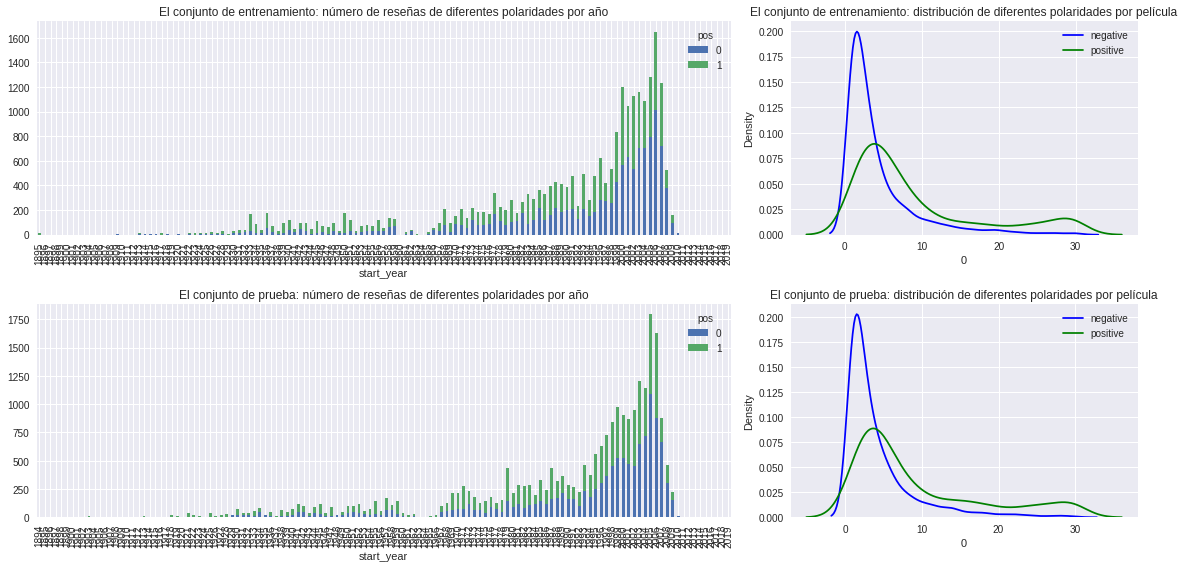

In [12]:
# Graficar distribución de variable durante el tiempo de los conjuntos de entrenamiento y prueba
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

Con estos gráficos podemos constatar que ambos set de entrenamiento y prueba contienen una distrubución de respuestas positivas y negativas equilibrada. Por lo tanto podemos concluir que no hay un desequilibrio de clases en nuestra data.

## Procedimiento de evaluación

Ahora crearemos una función que nos servirá para evaluar con diferentes métricas los modelos que probremos más adelante.

In [13]:
# Crear función de evaluación
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # Establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # Establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')   
        
        if len(target) != len(pred_target):
            print(f'Longitudes incompatibles: target={len(target)}, pred_target={len(pred_target)}')
        else:
            eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [14]:
# Convertir a minúsculas
df_reviews['review_norm'] = df_reviews['review'].str.lower()

# Eliminar dígitos
df_reviews['review_norm'] = df_reviews['review_norm'].str.replace('\d+', '', regex=True)

# Eliminar signos de puntuación
df_reviews['review_norm'] = df_reviews['review_norm'].str.replace('[^\w\s]', '', regex=True)

In [15]:
# Verificar resultados
df_reviews['review_norm']

0        the pakage implies that warren beatty and gold...
1        how the hell did they get this made presenting...
2        there is no real story the film seems more lik...
3        um  a serious film about troubled teens in sin...
4        im totally agree with garryjohal from singapor...
                               ...                        
47326    this is another of my favorite columbos it spo...
47327    talk about being boring i got this expecting a...
47328    i never thought id say this about a biopic but...
47329    spirit and chaos is an artistic biopic of miya...
47330    ill make this brief this was a joy to watch it...
Name: review_norm, Length: 47331, dtype: object

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [16]:
# Ver distribución de datos en los conjuntos
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Trabajar con modelos

### Modelo 0 - Constante

Antes de trabajar con nuestros modelos, crearemos un modelo constante que funcione como nuestra prueba de cordura. Si los modelos a probar obtienen valores menores en las métricas evaluadas, significa que el modelo no está funcionando correctamente.

In [17]:
# Crear un modelo constante que siempre predice la clase más frecuente
model_0 = DummyClassifier(strategy='most_frequent')

In [18]:
# Ajustar el modelo a tus datos de entrenamiento
model_0.fit(df_reviews_train['review_norm'], train_target)

DummyClassifier(strategy='most_frequent')

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


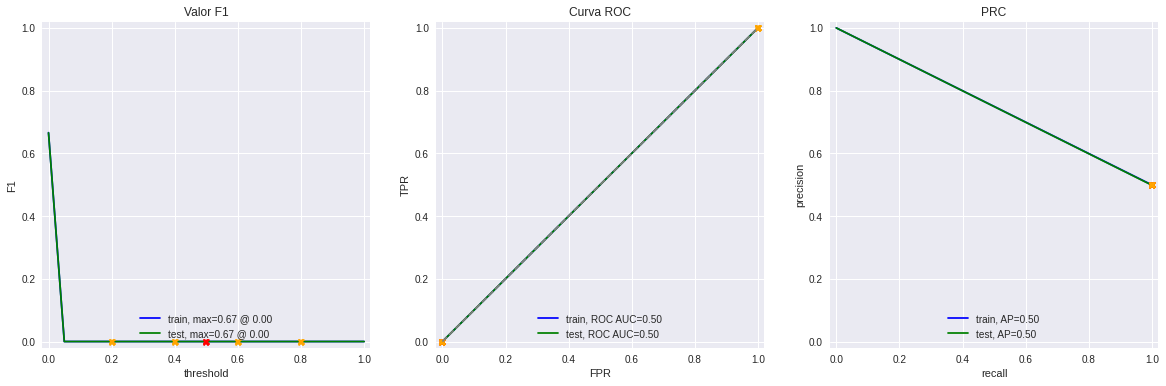

In [19]:
# Evaluar modelo de cordura
evaluate_model(model_0, df_reviews_train['review_norm'], train_target, df_reviews_test['review_norm'], test_target)

Nuestra prueba de cordura indica que nuestras métricas (F1, APS y ROC AUC) son de 0.5, utilizaremos esta valor para medir los demás modelos a continuación.

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [20]:
# Crear un vectorizador TF-IDF
stop_words = set(stopwords.words('english'))
count_tf_idf_1 = TfidfVectorizer(stop_words=stop_words)

# Ajustar el vectorizador a los datos de entrenamiento y transformarlos
train_features_1 = count_tf_idf_1.fit_transform(df_reviews_train['review_norm'])

# Transformar los datos de prueba
test_features_1 = count_tf_idf_1.transform(df_reviews_test['review_norm'])

In [21]:
# Entrenar una regresión logística
model_1 = LogisticRegression()
model_1.fit(train_features_1, train_target)

LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


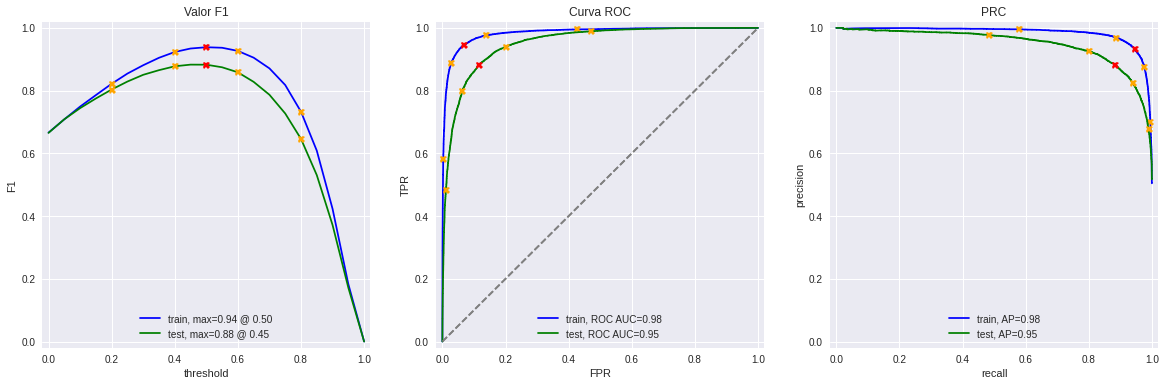

In [22]:
# Evaluar modelo
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

Nuestro modelo es casi perfecto llegando a valores cercanos a 1 a pesar que en el conjunto de pruebas nuestras métricas no son tan altas que en el de entrenamiento.

### Modelo 2 - spaCy, TF-IDF y LR

In [23]:
# Crear nlp
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [24]:
# Crear función de procesamiento de texto
def text_preprocessing_3(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    #tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [25]:
# Crear un vectorizador TF-IDF
stop_words = set(stopwords.words('english'))
count_tf_idf_2 = TfidfVectorizer(stop_words=stop_words)

# Ajustar el vectorizador a los datos de entrenamiento y transformarlos
train_features_2 = count_tf_idf_2.fit_transform(df_reviews_train['review_norm'].apply(text_preprocessing_3))

# Transformar los datos de prueba
test_features_2 = count_tf_idf_2.transform(df_reviews_test['review_norm'].apply(text_preprocessing_3))

In [26]:
# Entrenar una regresión logística
model_2 = LogisticRegression()
model_2.fit(train_features_2, train_target)

LogisticRegression()

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


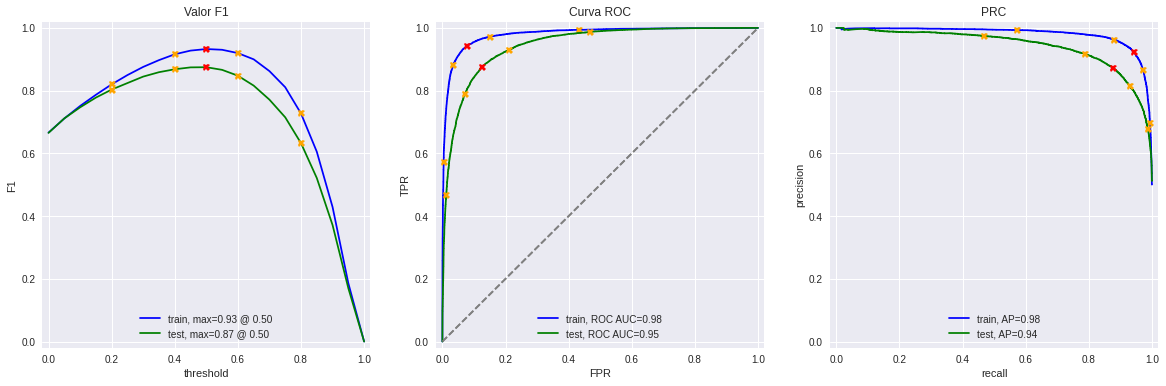

In [27]:
# Evaluar modelo
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

Utilizando spaCy nuestro modelo es solo un poco exacto que usando NLTK, pero igualmente muy certero al momento de precidir los valores.

### Modelo 3 - spaCy, TF-IDF y LGBMClassifier

**Ajuste de Hiperparámetros**

In [28]:
# Establecer los hiperparámetros que vamos a ajustar
params_lightgbm = {
    'n_estimators': [100, 500], 
    'learning_rate': [0.2, 0.5, 0.7], 
    'num_leaves': [10, 20]
}

# Llamar al estimador que utilizaremos
lightgbm_est = LGBMClassifier(n_jobs=-1)

# Usar la función RandomizedSearchCV y pasamos los hiperparámetros establecidos, la métrica y el valor para la validación cruzada
randSearch_lightgbm = RandomizedSearchCV(
    estimator=lightgbm_est,
    param_distributions=params_lightgbm,
    scoring='accuracy',
    cv=3,
    n_iter=10,  # Puedes ajustar este número según la cantidad de combinaciones que desees probar
    random_state=42  # para reproducibilidad
)

In [29]:
# Entrenar nuestro modelo para encontrar los mejores hiperparámetros
randSearch_lightgbm.fit(
    train_features_2,
    train_target,
    **{'early_stopping_rounds':10, 'eval_metric' : 'auc', 
       'eval_set' : [(test_features_2, test_target)], 'verbose': False}
)

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecat

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(),
                   param_distributions={'learning_rate': [0.2, 0.5, 0.7],
                                        'n_estimators': [100, 500],
                                        'num_leaves': [10, 20]},
                   random_state=42, scoring='accuracy')

In [30]:
# Encontrar los mejores hiperparámetros
best_set_of_params = randSearch_lightgbm.best_params_
best_score = randSearch_lightgbm.best_score_

print(f'Mejores hiperparámetros: {best_set_of_params} | Mejor RECM: {-best_score:.3f}')

Mejores hiperparámetros: {'num_leaves': 10, 'n_estimators': 500, 'learning_rate': 0.2} | Mejor RECM: -0.852


**Entrenamiento de Modelo**

In [31]:
# Entrenar el modelo de LightGBM
lightgbm_model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.2,
    num_leaves=10,
    random_seed=12345
)

lightgbm_model.fit(train_features_2, train_target)

LGBMClassifier(learning_rate=0.2, n_estimators=500, num_leaves=10,
               random_seed=12345)

          train  test
Accuracy   0.97  0.86
F1         0.97  0.86
APS        1.00  0.94
ROC AUC    1.00  0.94


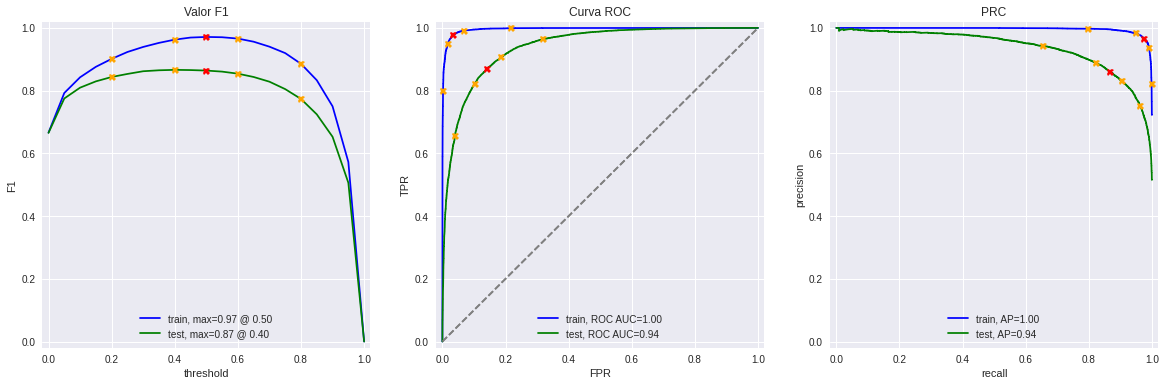

In [32]:
# Evaluar modelo
evaluate_model(lightgbm_model, train_features_2, train_target, test_features_2, test_target)

Utilizando LGBMClassifier nuestro modelo no es mejor que los anteriores, pero sigue siendo un modelo de alta exactitud.

###  Modelo 4 - BERT

El siguiente modelo no será ejecutado debido a la cantidad de recursos haría que el modelo demore mucho tiempo en ejecutarse.

In [33]:
# Crear tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
# Crear función de embeddings de texto con Bert
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []
    
    for input_text in texts:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
        
        
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')
    
    # obtener insertados en lotes
    
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [35]:
# La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas por eso no se ejecuta
#train_features_5 = BERT_text_to_embeddings(df_reviews_train.iloc[:100]['review_norm'], force_device='cuda')
#test_features_5 = BERT_text_to_embeddings(df_reviews_test.iloc[:100]['review_norm'], force_device='cuda')

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_5.shape)
print(train_target.shape)

In [ ]:
# Entrenar una regresión logística
model_4 = LogisticRegression()
model_4.fit(train_features_5, train_target)

In [ ]:
# Evaluar modelos

evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)

In [ ]:
# Guardar los resultados
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# y cargar...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## Mis reseñas

Por último pondremos algunos ejemplos de reviews y los próbaremos con nuestros modeloes para ver que tan bien funcionan en la práctica.

In [36]:
# Crear reviews de prueba
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

# Convertir a minúsculas
my_reviews['review_norm'] = df_reviews['review'].str.lower()

# Eliminar dígitos
my_reviews['review_norm'] = df_reviews['review_norm'].str.replace('\d+', '', regex=True)

# Eliminar signos de puntuación
my_reviews['review_norm'] = df_reviews['review_norm'].str.replace('[^\w\s]', '', regex=True)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",the pakage implies that warren beatty and gold...
1,"Well, I was bored and felt asleep in the middl...",how the hell did they get this made presenting...
2,I was really fascinated with the movie,there is no real story the film seems more lik...
3,Even the actors looked really old and disinter...,um a serious film about troubled teens in sin...
4,I didn't expect the reboot to be so good! Writ...,im totally agree with garryjohal from singapor...
5,"The movie had its upsides and downsides, but I...",this is the first movie ive seen from singapor...
6,What a rotten attempt at a comedy. Not a singl...,yes nonsingaporeans cant see whats the big dea...
7,Launching on Netflix was a brave move & I real...,this true story of carlsons raiders is more of...


### Modelo 1

In [45]:
# Probar modelo
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(count_tf_idf_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.06:  the pakage implies that warren beatty and goldie hawn are pulling off a huge bank robbery but thats 
0.12:  how the hell did they get this made presenting itself as a caper comedy the misbegotten  is essentia
0.38:  there is no real story the film seems more like a fly on the wall dramadocumentary than a proper fil
0.84:  um  a serious film about troubled teens in singapore a country i have not much knowledge on but have
0.66:  im totally agree with garryjohal from singapores comments about this film quotation yes nonsingapore
0.89:  this is the first movie ive seen from singapore and its great if you dont know a lot about asia its 
0.66:  yes nonsingaporeans cant see whats the big deal about this film some of the references in this film 
0.30:  this true story of carlsons raiders is more of a army training film than anything elseobviously thro


### Modelo 2

In [37]:
# Probar modelo
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(count_tf_idf_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.10:  the pakage implies that warren beatty and goldie hawn are pulling off a huge bank robbery but thats 
0.28:  how the hell did they get this made presenting itself as a caper comedy the misbegotten  is essentia
0.35:  there is no real story the film seems more like a fly on the wall dramadocumentary than a proper fil
0.56:  um  a serious film about troubled teens in singapore a country i have not much knowledge on but have
0.67:  im totally agree with garryjohal from singapores comments about this film quotation yes nonsingapore
0.81:  this is the first movie ive seen from singapore and its great if you dont know a lot about asia its 
0.67:  yes nonsingaporeans cant see whats the big deal about this film some of the references in this film 
0.40:  this true story of carlsons raiders is more of a army training film than anything elseobviously thro


### Modelo 3

In [40]:
# Probar modelo
texts = my_reviews['review_norm']

my_reviews_pred_prob = lightgbm_model.predict_proba(count_tf_idf_2.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.00:  the pakage implies that warren beatty and goldie hawn are pulling off a huge bank robbery but thats 
0.02:  how the hell did they get this made presenting itself as a caper comedy the misbegotten  is essentia
0.29:  there is no real story the film seems more like a fly on the wall dramadocumentary than a proper fil
0.83:  um  a serious film about troubled teens in singapore a country i have not much knowledge on but have
0.35:  im totally agree with garryjohal from singapores comments about this film quotation yes nonsingapore
0.87:  this is the first movie ive seen from singapore and its great if you dont know a lot about asia its 
0.77:  yes nonsingaporeans cant see whats the big deal about this film some of the references in this film 
0.36:  this true story of carlsons raiders is more of a army training film than anything elseobviously thro


### Modelo 4

No se hará la prueba del modelo debido a que no se ejecutó el modelo de Bert debido al tiempo que toma este.

In [ ]:
# Porbar modelo
texts = my_reviews['review_norm']

my_reviews_features_5 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_5.predict_proba(my_reviews_features_5)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusiones

Iniciamos nuestro análisis enfocándonos en las reseñas de las películas. Observamos que la cantidad de reseñas ha aumentado con el tiempo. Además, notamos que la mayoría de las películas recibe entre 1 y 9 reseñas, aunque también hay una cantidad significativa que llega a aproximadamente 30 reseñas. Para evaluar el rendimiento de nuestros modelos, desarrollamos una función que utiliza métricas como F1, APS y ROC AUC. Finalmente, creamos, evaluamos y probamos varios modelos para determinar su eficacia.

A continuación se presentan las conclusiones respecto a los modelos:

**1. El modelo más exacto resultó ser el modelo de LightGBM con una exactitud de 0.97, F1 de 0.97, APS de 1 y ROC AUC 1.**

**2. El mejor modelo en práctica utilizando nuestras propieas reseñas fue el modelo_1 (NLTK, TF-IDF y LR), con un promedio de exactitud de 0.49.**